In [1]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import json

# --- Path Setup ---
if os.path.basename(os.getcwd()) == 'notebooks':
    PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), ".."))
else:
    PROJECT_ROOT = os.path.abspath(os.getcwd())
SRC_PATH = os.path.join(PROJECT_ROOT, "src")
if SRC_PATH not in sys.path:
    sys.path.insert(0, SRC_PATH)

from pipeline_config import CONFIG

# --- Directories ---
DERIV_03 = os.path.join(PROJECT_ROOT, CONFIG['derivatives_dir'], "step_03_resample")
DERIV_04 = os.path.join(PROJECT_ROOT, CONFIG['derivatives_dir'], "step_04_filtering")
os.makedirs(DERIV_04, exist_ok=True)

# --- Metadata Validation for Biomechanical Analysis ---
# RATIONALE: To compute Kinetic Energy and Center of Mass (CoM) in later steps, 
# subject mass and height are required for scaling (Winter, 2009).
SUBJECT_MASS = CONFIG.get('subject_mass_kg', None)
SUBJECT_HEIGHT = CONFIG.get('subject_height_cm', None)
HEIGHT_ESTIMATED = CONFIG.get('subject_height_estimated', False)
HEIGHT_CALCULATION_METHOD = CONFIG.get('height_estimation_method', None)

if SUBJECT_MASS is None or SUBJECT_HEIGHT is None:
    print("⚠️ WARNING: Subject mass or height missing in CONFIG. "
          "Kinetic calculations in Notebook 08 will be normalized (0-1) instead of absolute.")
else:
    if HEIGHT_ESTIMATED:
        method_display = HEIGHT_CALCULATION_METHOD.replace('_', ' ').title() if HEIGHT_CALCULATION_METHOD else "calculated"
        height_note = f" (height {method_display} from mocap)"
    else:
        height_note = ""
    print(f"✅ Anthropometric Data Loaded: {SUBJECT_MASS}kg, {SUBJECT_HEIGHT}cm{height_note}")

# --- File Loading ---
csv_filename = Path(CONFIG['current_csv']).stem
RUN_ID = csv_filename
INPUT_FILE = Path(DERIV_03) / f"{RUN_ID}__resampled.parquet"

if not INPUT_FILE.exists():
    raise FileNotFoundError(f"Missing input: {INPUT_FILE}. Please run Notebook 03.")

df = pd.read_parquet(INPUT_FILE)
print(f"✅ Data Loaded successfully. Ready for Signal Filtering.")
print("(Winter, 2009) Kinematic data were smoothed using a fourth-order low-pass Butterworth filter with a cut-off frequency of X Hz. To eliminate phase shift, a zero-phase lag dual-pass technique (filtfilt) was applied.")

⚠️ WARNING: Subject mass or height missing in CONFIG. Kinetic calculations in Notebook 08 will be normalized (0-1) instead of absolute.
✅ Data Loaded successfully. Ready for Signal Filtering.
(Winter, 2009) Kinematic data were smoothed using a fourth-order low-pass Butterworth filter with a cut-off frequency of X Hz. To eliminate phase shift, a zero-phase lag dual-pass technique (filtfilt) was applied.


In [ ]:
# --- SCIENTIFIC UPGRADE: Signal-to-Noise Ratio (SNR) Analysis ---
# Per Cereatti et al. (2024) - Objective signal quality assessment

print("\n" + "="*80)
print("TRUE RAW SNR - CAPTURE QUALITY (Cereatti et al. 2024)")
print("="*80)
print("Method: Raw data frequency analysis (signal: 0.5-10Hz, noise: 15-50Hz)")
print("This measures inherent capture quality, NOT filtering effectiveness.")

from snr_analysis import compute_per_joint_snr, generate_snr_report

# Get joint names from position columns
pos_cols = get_position_columns(df_filtered)
joint_names = list(set(c.split('__')[0] for c in pos_cols))

print(f"Computing SNR for {len(joint_names)} joints...")

# Compute TRUE RAW SNR (from raw data frequency analysis)
# Signal: 0.5-10Hz (movement), Noise: 15-50Hz (both from RAW)
# This measures capture quality, NOT filtering effectiveness
snr_results = compute_per_joint_snr(
    df_raw=df,  # Raw data only - true SNR from frequency bands
    df_filtered=df_filtered,  # Not used for true_raw method
    joint_names=joint_names,
    fs=FS,
    method='true_raw'
)

# Generate summary report
snr_report = generate_snr_report(snr_results, min_acceptable_snr=15.0)

print(f"\nSNR Summary:")
print(f"  Mean SNR (all joints): {snr_report['mean_snr_all_joints']:.1f} dB")
print(f"  Range: [{snr_report['min_snr_all_joints']:.1f}, {snr_report['max_snr_all_joints']:.1f}] dB")
print(f"  Overall Status: {snr_report['overall_status']}")
print(f"\nQuality Breakdown:")
print(f"  ✅⭐ Excellent (>30 dB): {snr_report['joints_excellent']}")
print(f"  ✅  Good (20-30 dB): {snr_report['joints_good']}")
print(f"  ⚠️  Acceptable (15-20 dB): {snr_report['joints_acceptable']}")
print(f"  🟡  Poor (10-15 dB): {snr_report['joints_poor']}")
print(f"  ❌  Below Threshold (<10 dB): {snr_report['joints_reject']}")

if snr_report['failed_joints']:
    print(f"\n⚠️  {len(snr_report['failed_joints'])} Joints Below 15 dB Threshold:")
    for joint in snr_report['failed_joints'][:10]:
        result = snr_results[joint]
        print(f"    {joint}: {result['mean_snr_db']:.1f} dB - {result['recommendation']}")
else:
    print(f"\n✅ All joints meet minimum SNR threshold (15 dB)")

print("="*80)

In [2]:
# --- CELL 02: Filter Method & Config (from config_v1.yaml) ---
# Method and all parameters are read from config_v1.yaml.

# Import filtering module
from filtering import (
    apply_winter_filter, 
    apply_signal_cleaning_pipeline,
    apply_quaternion_median_filter,
    print_pipeline_debug_logs,
    get_position_columns, 
    validate_filtering_input
)

FS = CONFIG.get('fs_target', 120.0)
FILTER_CONFIG = CONFIG.get('filtering', {})
FILTER_METHOD = FILTER_CONFIG.get('method', '3_stage').strip().lower()
FMAX = FILTER_CONFIG.get('fmax', 12.0)

print(f"✅ Filtering config read from config_v1.yaml")
print()

# 1. Which method is selected
METHOD_LABELS = {
    'per_region': ('A', 'Per-region fixed cutoffs (Winter 2009, Robertson 2014)'),
    '3_stage':     ('B', '3-stage pipeline (Artifact + Hampel + Adaptive Winter per-joint)'),
    'single_global': ('C', 'Single global cutoff (one cutoff for all joints)')
}
letter, label = METHOD_LABELS.get(FILTER_METHOD, ('?', f'Unknown method: {FILTER_METHOD}'))
print(f"   Selected method: {letter}. {label}")
print()

# 2. Variables currently set and applied for this method
print(f"   Parameters applied (from config_v1.yaml) for method = {FILTER_METHOD}:")
if FILTER_METHOD == '3_stage':
    print(f"      velocity_limit:        {FILTER_CONFIG.get('velocity_limit', 5000.0)} mm/s")
    print(f"      zscore_threshold:      {FILTER_CONFIG.get('zscore_threshold', 5.0)} σ")
    print(f"      stage1_interpolation_method: {FILTER_CONFIG.get('stage1_interpolation_method', 'pchip')}")
    print(f"      hampel_window:         {FILTER_CONFIG.get('hampel_window', 5)} frames")
    print(f"      hampel_n_sigma:        {FILTER_CONFIG.get('hampel_n_sigma', 3.0)} σ")
    print(f"      winter_fmin:           {FILTER_CONFIG.get('winter_fmin', 1.0)} Hz")
    print(f"      winter_fmax:           {FILTER_CONFIG.get('winter_fmax', 20.0)} Hz")
    print(f"      per_joint_winter:      {FILTER_CONFIG.get('per_joint_winter', True)}")
elif FILTER_METHOD == 'per_region':
    print(f"      fmax:                  {FILTER_CONFIG.get('fmax', 12.0)} Hz")
    print(f"      allow_fmax:            {FILTER_CONFIG.get('allow_fmax', True)}")
    print(f"      (Region cutoffs: Trunk 6 Hz | Head 8 Hz | Proximal 8 Hz | Distal 10 Hz)")
elif FILTER_METHOD == 'single_global':
    print(f"      cutoff_hz:             {FILTER_CONFIG.get('cutoff_hz', 8.0)} Hz")
print(f"      apply_quaternion_median_filter: {FILTER_CONFIG.get('apply_quaternion_median_filter', True)}")
print(f"      quaternion_window_size:  {FILTER_CONFIG.get('quaternion_window_size', 5)} frames")
print()
print(f"   Filter: 2nd-order Butterworth (zero-phase). Effective order: 4 (dual-pass).")

✅ Filtering config read from config_v1.yaml

   Selected method: B. 3-stage pipeline (Artifact + Hampel + Adaptive Winter per-joint)

   Parameters applied (from config_v1.yaml) for method = 3_stage:
      velocity_limit:        5000.0 mm/s
      zscore_threshold:      5.0 σ
      stage1_interpolation_method: pchip
      hampel_window:         5 frames
      hampel_n_sigma:        3.0 σ
      winter_fmin:           1.0 Hz
      winter_fmax:           20.0 Hz
      per_joint_winter:      True
      apply_quaternion_median_filter: True
      quaternion_window_size:  5 frames

   Filter: 2nd-order Butterworth (zero-phase). Effective order: 4 (dual-pass).


In [3]:
# --- CELL 03: Position Column Quality Control (Ticket 10.5) ---
# RATIONALE: Filtering should only be applied to position channels 
# that are fully valid (zero NaNs) to prevent artifacts and ensure 
# biomechanical integrity of joint kinematics.

from qc_columns import build_pos_cols_valid

# Extract position columns
pos_cols = [c for c in df.columns if c.endswith(("__px","__py","__pz"))]

# Build valid position columns list and exclusion report
pos_cols_valid, excluded_report = build_pos_cols_valid(
    df, 
    pos_cols, 
    strict_mode=True, 
    joint_complete_axes=True
)

print(f"[QC] Positions valid: {len(pos_cols_valid)}/{len(pos_cols)}")
print(f"[QC] Excluded joints: {len(excluded_report['excluded_joints'])}")

# Save the exclusion report for QC traceability
qc_report_path = os.path.join(DERIV_04, f"{RUN_ID}__qc_excluded_positions.json")
with open(qc_report_path, "w") as f:
    json.dump(excluded_report, f, indent=2)
print(f"[QC] Saved exclusion report: {qc_report_path}")

# Display exclusion summary for user awareness
if excluded_report['excluded_joints']:
    print("\n[QC] Excluded joints summary:")
    for joint_info in excluded_report['excluded_joints']:
        print(f"  - {joint_info['joint']}: {joint_info['reason']} "
              f"(max NaN rate: {joint_info['max_nan_rate']:.2%})")

if excluded_report['excluded_cols']:
    print(f"\n[QC] Individual excluded columns: {len(excluded_report['excluded_cols'])}")
    for col_info in excluded_report['excluded_cols'][:5]:  # Show first 5
        print(f"  - {col_info['col']}: {col_info['reason']} "
              f"(NaN rate: {col_info['nan_rate']:.2%})")
    if len(excluded_report['excluded_cols']) > 5:
        print(f"  ... and {len(excluded_report['excluded_cols']) - 5} more")

print(f"\n[QC] Using {len(pos_cols_valid)} valid position columns for filtering.")

[QC] Positions valid: 57/57
[QC] Excluded joints: 0
[QC] Saved exclusion report: c:\Users\drorh\OneDrive - Mobileye\Desktop\gaga\derivatives\step_04_filtering\763_T2_P2_R2_Take_2025-12-25 10.51.23 AM_005__qc_excluded_positions.json

[QC] Using 57 valid position columns for filtering.


In [4]:
# --- CELL 04: Signal Cleaning Pipeline (POSITIONS ONLY) ---
# CRITICAL: Never filter quaternions - violates rotational geometry (Ticket 10)
# Method and parameters from config_v1.yaml (set in Cell 02).

pos_cols_to_filter = pos_cols_valid  # From QC step above
quat_cols = [c for c in df.columns if c.endswith(('__qx', '__qy', '__qz', '__qw'))]

print(f"📊 Position columns: {len(pos_cols_to_filter)} (method = {FILTER_METHOD})")
print(f"🔄 Quaternion columns: {len(quat_cols)} (median filter for flip removal)")

validate_filtering_input(df, FS, pos_cols_to_filter)

if FILTER_METHOD == '3_stage':
    # ========================================================================
    # 3-STAGE SIGNAL CLEANING PIPELINE
    # ========================================================================
    # Generic "Gatekeeper" Architecture: Treats artifacts and noise separately
    print(f"\n{'='*70}")
    print(f"🔬 APPLYING 3-STAGE SIGNAL CLEANING PIPELINE")
    print(f"{'='*70}")
    print(f"Stage 1: Artifact Detector (Z-Score + Velocity)")
    print(f"  → Identifies tracking spikes (>5000 mm/s or >5σ)")
    print(f"Stage 2: Hampel Filter (Sliding Window Median)")
    print(f"  → Removes outliers using 5-7 frame window")
    print(f"Stage 3: Adaptive Winter (Per-Joint Optimal Cutoff)")
    print(f"  → Finds optimal cutoff for each joint using residual analysis")
    print(f"{'='*70}\n")
    
    # Apply 3-stage pipeline (params from config_v1.yaml)
    df_filtered, pipeline_metadata = apply_signal_cleaning_pipeline(
        df,
        fs=FS,
        pos_cols=pos_cols_to_filter,
        velocity_limit=FILTER_CONFIG.get('velocity_limit', 5000.0),
        zscore_threshold=FILTER_CONFIG.get('zscore_threshold', 5.0),
        hampel_window=FILTER_CONFIG.get('hampel_window', 5),
        hampel_n_sigma=FILTER_CONFIG.get('hampel_n_sigma', 3.0),
        winter_fmin=FILTER_CONFIG.get('winter_fmin', 1.0),
        winter_fmax=FILTER_CONFIG.get('winter_fmax', 20.0),
        per_joint_winter=FILTER_CONFIG.get('per_joint_winter', True),
        stage1_interpolation_method=FILTER_CONFIG.get('stage1_interpolation_method', 'pchip')
    )
    
    # Display pipeline results
    summary = pipeline_metadata.get('summary', {})
    n_frames = summary.get('n_frames_total', 0)
    n_cols = summary.get('total_columns_processed', 1)
    total_samples = n_frames * n_cols if n_frames and n_cols else 0
    print(f"\n✅ 3-Stage Pipeline Complete")
    print(f"   Total frames in data: {n_frames} | Total position samples: {total_samples} (frames × columns)")
    print(f"   Artifacts detected: {summary.get('total_artifact_frames', 0)} frames ({summary.get('artifact_frames_pct', 0):.2f}% of position samples)")
    print(f"   Hampel outliers: {summary.get('total_hampel_outliers', 0)} frames ({summary.get('hampel_frames_pct', 0):.2f}% of position samples)")
    
    if 'winter_cutoff_stats' in summary:
        cutoff_stats = summary['winter_cutoff_stats']
        print(f"\n   Adaptive Winter Cutoffs (per-joint):")
        print(f"     Range: {cutoff_stats['min']:.1f} - {cutoff_stats['max']:.1f} Hz")
        print(f"     Mean: {cutoff_stats['mean']:.1f} Hz | Median: {cutoff_stats['median']:.1f} Hz")
    
    # Print detailed debug logs
    print_pipeline_debug_logs(
        pipeline_metadata,
        top_n_joints=20,  # Show top 20 joints with most issues
        show_all=False     # Set to True to show all joints
    )
    
    # Convert pipeline metadata to winter_metadata format for compatibility
    winter_metadata = {
        'filtering_mode': '3_stage_pipeline',
        'pipeline_metadata': pipeline_metadata,
        'cutoff_range': (
            summary.get('winter_cutoff_stats', {}).get('min', 1.0),
            summary.get('winter_cutoff_stats', {}).get('max', 20.0)
        ) if 'winter_cutoff_stats' in summary else (1.0, 20.0)
    }
    
elif FILTER_METHOD == 'per_region':
    # Fixed per-region cutoffs (Winter 2009, Robertson 2014) - params from config
    print(f"\nApplying fixed per-region cutoffs (Winter 2009, Robertson 2014) to {len(pos_cols_to_filter)} position columns...")
    df_filtered, winter_metadata = apply_winter_filter(
        df, fs=FS, pos_cols=pos_cols_to_filter,
        fmax=int(FMAX),
        allow_fmax=FILTER_CONFIG.get('allow_fmax', True),
        per_region_filtering=True
    )
    if winter_metadata.get('filtering_mode') in ('per_region', 'per_region_fixed'):
        print(f"✅ Per-Region Filtering Applied")
        print(f"   Region-specific cutoffs:")
        for region, cutoff in winter_metadata.get('region_cutoffs', {}).items():
            n_markers = len([m for m, r in winter_metadata.get('marker_regions', {}).items() if r == region])
            print(f"     {region:20s}: {cutoff:4.1f} Hz ({n_markers} markers)")
        cutoff_range = winter_metadata.get('cutoff_range', (0, 0))
        print(f"   Cutoff range: {cutoff_range[0]:.1f} - {cutoff_range[1]:.1f} Hz")
    else:
        if 'cutoff_hz' in winter_metadata:
            print(f"ℹ️  Single global cutoff mode: {winter_metadata['cutoff_hz']:.1f} Hz")

elif FILTER_METHOD == 'single_global':
    # One cutoff for all joints - from config
    cutoff_hz = FILTER_CONFIG.get('cutoff_hz', 8.0)
    print(f"\nApplying single global cutoff {cutoff_hz} Hz to {len(pos_cols_to_filter)} position columns...")
    df_filtered, winter_metadata = apply_winter_filter(
        df, fs=FS, pos_cols=pos_cols_to_filter,
        per_region_filtering=False,
        fixed_cutoff_hz=cutoff_hz
    )
    print(f"✅ Single-global filtering applied: {cutoff_hz} Hz")
    if 'cutoff_hz' in winter_metadata:
        print(f"   Cutoff: {winter_metadata['cutoff_hz']:.1f} Hz")

else:
    raise ValueError(f"Unknown filtering method in config: '{FILTER_METHOD}'. Use '3_stage', 'per_region', or 'single_global'.")

# QUATERNION SURGICAL CLEANING (scipy.signal.medfilt) - from config_v1.yaml
APPLY_QUATERNION_MEDIAN_FILTER = FILTER_CONFIG.get('apply_quaternion_median_filter', True)
QUAT_WINDOW = FILTER_CONFIG.get('quaternion_window_size', 5)

if APPLY_QUATERNION_MEDIAN_FILTER:
    print(f"\n{'='*70}")
    print(f"🔧 APPLYING scipy.signal.medfilt TO QUATERNIONS")
    print(f"{'='*70}")
    print(f"   Method: scipy.signal.medfilt")
    print(f"   Window size: {QUAT_WINDOW} frames")
    print(f"   Purpose: Remove quaternion flips (330° Hip ROM fix)")
    
    df_filtered, quat_metadata = apply_quaternion_median_filter(
        df_filtered, quat_cols=quat_cols, window_size=QUAT_WINDOW
    )
    
    print(f"\n✅ Quaternion Median Filter Complete")
    print(f"   Method: {quat_metadata.get('method', 'medfilt')}")
    print(f"   Joints processed: {quat_metadata.get('total_joints', 0)}")
    print(f"   Columns filtered: {quat_metadata.get('total_columns_filtered', 0)}")
    print(f"   All quaternions renormalized to unit length")
    print(f"{'='*70}")
    
    # Store quaternion metadata in winter_metadata for export
    if 'pipeline_metadata' in winter_metadata:
        winter_metadata['pipeline_metadata']['quaternion_cleaning'] = quat_metadata
    else:
        winter_metadata['quaternion_cleaning'] = quat_metadata
else:
    # Legacy: Copy quaternions unchanged
    for col in quat_cols:
        df_filtered[col] = df[col].values
    print(f"\n⚠️  Quaternions preserved unchanged (median filter disabled)")

print(f"\n✅ Filtered {len(pos_cols_to_filter)} position columns")
print(f"✅ {'Cleaned' if APPLY_QUATERNION_MEDIAN_FILTER else 'Preserved'} {len(quat_cols)} quaternion columns")

📊 Position columns: 57 (method = 3_stage)
🔄 Quaternion columns: 76 (median filter for flip removal)

🔬 APPLYING 3-STAGE SIGNAL CLEANING PIPELINE
Stage 1: Artifact Detector (Z-Score + Velocity)
  → Identifies tracking spikes (>5000 mm/s or >5σ)
Stage 2: Hampel Filter (Sliding Window Median)
  → Removes outliers using 5-7 frame window
Stage 3: Adaptive Winter (Per-Joint Optimal Cutoff)
  → Finds optimal cutoff for each joint using residual analysis


✅ 3-Stage Pipeline Complete
   Total frames in data: 17262 | Total position samples: 983934 (frames × columns)
   Artifacts detected: 1368 frames (0.14% of position samples)
   Hampel outliers: 1018 frames (0.10% of position samples)

   Adaptive Winter Cutoffs (per-joint):
     Range: 14.5 - 15.2 Hz
     Mean: 14.6 Hz | Median: 14.5 Hz

📊 DETAILED PIPELINE DEBUG LOGS

🔧 PIPELINE CONFIGURATION:
   Stage 1 (Artifact Detector):
     - Velocity limit: 5000.0 mm/s
     - Z-score threshold: 5.0σ
     - Interpolation method: pchip (documented)
   

# VALIDATION SECTION 1: Filter PSD Analysis

**Research Validation**: Verify that filtering (any method: per-region, single-global, or 3-stage) preserves dance dynamics (1-15 Hz) while attenuating noise (>20 Hz)

**Methods**: Power Spectral Density (PSD) analysis using Welch's method

**Expected**: Dance band preservation >80%, Noise attenuation >95%

In [8]:
# Import validation modules
from filter_validation import (
    compute_psd_welch,
    analyze_filter_psd_preservation,
    validate_filter_quality,
    generate_psd_plots_data
)

# PSD validation bands from config (e.g. validation_dance_band_hz: [1, 13])
FILTER_CONFIG = CONFIG.get("filtering", {})
DANCE_BAND = tuple(FILTER_CONFIG.get("validation_dance_band_hz", [1, 15]))
NOISE_BAND = tuple(FILTER_CONFIG.get("validation_noise_band_hz", [20, 50]))

# One column per joint (19 markers): prefer __px for consistency
joint_to_col = {}
for col in pos_cols:
    joint = col.rsplit("__", 1)[0]
    if joint not in joint_to_col:
        joint_to_col[joint] = col
cols_one_per_joint = [joint_to_col[j] for j in sorted(joint_to_col)]
n_markers = len(cols_one_per_joint)

def get_effective_cutoff(col):
    """Get cutoff (Hz) for a position column based on filtering mode."""
    fm = winter_metadata.get("filtering_mode", "single_global")
    if fm == "3_stage_pipeline":
        pm = winter_metadata.get("pipeline_metadata", {})
        c = pm.get("per_joint_results", {}).get(col, {}).get("stage3_winter_cutoff")
        if c is not None:
            return c
        return pm.get("summary", {}).get("winter_cutoff_stats", {}).get("mean", 10.0)
    if fm in ("per_region", "per_region_fixed"):
        region = winter_metadata.get("marker_regions", {}).get(col, "unknown")
        c = winter_metadata.get("region_cutoffs", {}).get(region)
        if c is not None:
            return c
        r = winter_metadata.get("cutoff_range", (8, 12))
        return (r[0] + r[1]) / 2
    return winter_metadata.get("cutoff_hz", 10.0)

# Validate all markers
all_results = []
for col in cols_one_per_joint:
    joint_name = col.rsplit("__", 1)[0]
    cutoff = get_effective_cutoff(col)
    raw = df[col].values
    filt = df_filtered[col].values
    psd = analyze_filter_psd_preservation(raw, filt, FS, cutoff_hz=cutoff, dance_band=DANCE_BAND, noise_band=NOISE_BAND)
    qual = validate_filter_quality(psd)
    noise_atten_pct = (1 - psd["power_filt_noise"] / psd["power_raw_noise"]) * 100 if psd["power_raw_noise"] > 0 else 100.0
    dance_pass = psd["dance_preservation_pct"] >= 80
    noise_pass = noise_atten_pct >= 95
    all_results.append({
        "joint": joint_name, "col": col, "cutoff": cutoff,
        "psd_result": psd, "quality": qual,
        "dance_preservation_pct": psd["dance_preservation_pct"],
        "noise_attenuation_pct": noise_atten_pct,
        "snr_improvement_db": psd["snr_improvement_db"],
        "dance_pass": dance_pass, "noise_pass": noise_pass,
    })

# Summary over all 19 (dance preservation capped at 100% for display: ratio can slightly exceed 1)
dance_pcts = [r["dance_preservation_pct"] for r in all_results]
dance_pcts_capped = [min(100.0, p) for p in dance_pcts]
noise_pcts = [r["noise_attenuation_pct"] for r in all_results]
snr_dbs = [r["snr_improvement_db"] for r in all_results]
dance_pass_count = sum(r["dance_pass"] for r in all_results)
noise_pass_count = sum(r["noise_pass"] for r in all_results)

filtering_mode = winter_metadata.get("filtering_mode", "single_global")
print(f"Filter mode: {filtering_mode}. Validated {n_markers} markers (one position column per joint).")
print("\nWhat was calculated (per marker, Welch PSD):")
print(f"  - Dance preservation: (power in {DANCE_BAND[0]}-{DANCE_BAND[1]} Hz after filter) / (power before) x 100; >100% capped at 100% for display.")
print(f"  - Noise attenuation: (1 - power in {NOISE_BAND[0]}-{NOISE_BAND[1]} Hz after / before) x 100; fraction of noise-band power removed.")
print("  - SNR improvement: 10*log10(SNR_after/SNR_before) in dB; SNR = dance-band power / noise-band power.")
print("\n" + "="*60)
print("FILTER VALIDATION SUMMARY (all markers)")
print("="*60)
print(f"  Dance preservation ({DANCE_BAND[0]}-{DANCE_BAND[1]} Hz):  {dance_pass_count}/{n_markers} markers >= 80%  (min/mean/max: {min(dance_pcts_capped):.1f} / {sum(dance_pcts_capped)/n_markers:.1f} / {max(dance_pcts_capped):.1f}%)")
print(f"  Noise attenuation ({NOISE_BAND[0]}-{NOISE_BAND[1]} Hz):  {noise_pass_count}/{n_markers} markers >= 95%  (min/mean/max: {min(noise_pcts):.1f} / {sum(noise_pcts)/n_markers:.1f} / {max(noise_pcts):.1f}%)")
print(f"  SNR improvement (dB):         (min/mean/max: {min(snr_dbs):.1f} / {sum(snr_dbs)/n_markers:.1f} / {max(snr_dbs):.1f} dB)")
print("="*60)

# Example markers for plots: hand and trunk
example_hand_col = None
example_trunk_col = None
for col in cols_one_per_joint:
    j = col.rsplit("__", 1)[0]
    if example_hand_col is None and ("Hand" in j or "Wrist" in j):
        example_hand_col = col
    if example_trunk_col is None and any(p in j for p in ["Pelvis", "Torso", "Chest", "Spine"]):
        example_trunk_col = col
if example_hand_col is None:
    example_hand_col = cols_one_per_joint[0]
if example_trunk_col is None:
    example_trunk_col = cols_one_per_joint[min(1, n_markers - 1)]

# Set variables for example plots (hand = first, trunk = second)
hand_res = next(r for r in all_results if r["col"] == example_hand_col)
trunk_res = next(r for r in all_results if r["col"] == example_trunk_col)
test_marker = [example_hand_col]
signal_raw = df[example_hand_col].values
signal_filt = df_filtered[example_hand_col].values
effective_cutoff = hand_res["cutoff"]
psd_result = hand_res["psd_result"]
quality = hand_res["quality"]
# Trunk example (for second plot)
signal_raw_trunk = df[example_trunk_col].values
signal_filt_trunk = df_filtered[example_trunk_col].values
effective_cutoff_trunk = trunk_res["cutoff"]
psd_result_trunk = trunk_res["psd_result"]
quality_trunk = trunk_res["quality"]

Filter mode: 3_stage_pipeline. Validated 19 markers (one position column per joint).

What was calculated (per marker, Welch PSD):
  - Dance preservation: (power in 1-15 Hz after filter) / (power in 1-15 Hz before filter) x 100; >100% capped at 100% for display.
  - Noise attenuation: (1 - power in 20-50 Hz after / before) x 100; fraction of noise-band power removed.
  - SNR improvement: 10*log10(SNR_after/SNR_before) in dB; SNR = dance-band power / noise-band power.

FILTER VALIDATION SUMMARY (all markers)
  Dance preservation (1-15 Hz):  19/19 markers >= 80%  (min/mean/max: 99.8 / 99.9 / 100.0%)
  Noise attenuation (20-50 Hz):  19/19 markers >= 95%  (min/mean/max: 99.0 / 99.5 / 99.6%)
  SNR improvement (dB):         (min/mean/max: 20.1 / 22.9 / 23.9 dB)



PSD validation plot saved: 763_T2_P2_R2_Take_2025-12-25 10.51.23 AM_005__filter_psd_validation.png (hand + trunk examples, all-19 summary)


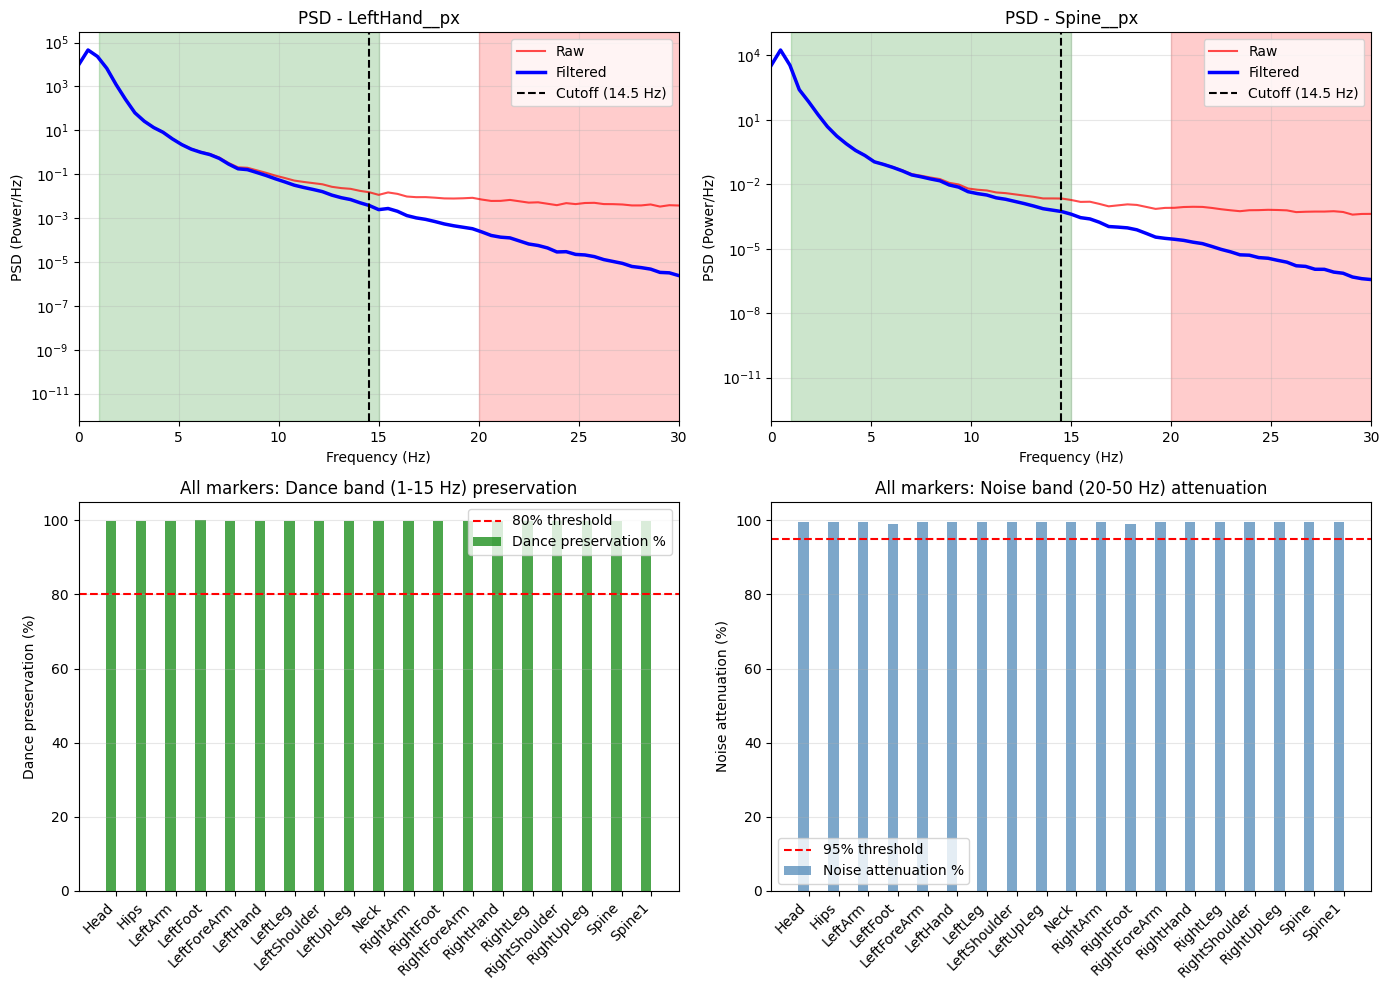

In [9]:
# Visualization: Example PSD plots (hand + trunk) and summary over all 19 markers
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Row 0: Example PSD plots (hand left, trunk right)
for ax, (sig_raw, sig_filt, res, label) in [
    (axes[0, 0], (signal_raw, signal_filt, hand_res, example_hand_col)),
    (axes[0, 1], (signal_raw_trunk, signal_filt_trunk, trunk_res, example_trunk_col)),
]:
    f_r, p_r = compute_psd_welch(sig_raw, FS)
    f_f, p_f = compute_psd_welch(sig_filt, FS)
    ax.semilogy(f_r, p_r, 'r-', label='Raw', alpha=0.7, linewidth=1.5)
    ax.semilogy(f_f, p_f, 'b-', label='Filtered', linewidth=2.5)
    ax.axvspan(DANCE_BAND[0], DANCE_BAND[1], alpha=0.2, color='green')
    ax.axvspan(NOISE_BAND[0], NOISE_BAND[1], alpha=0.2, color='red')
    ax.axvline(res["cutoff"], color='k', linestyle='--', label=f"Cutoff ({res['cutoff']:.1f} Hz)")
    ax.set_xlabel('Frequency (Hz)')
    ax.set_ylabel('PSD (Power/Hz)')
    ax.set_title(f'PSD - {label}')
    ax.legend()
    ax.grid(True, alpha=0.3)
    ax.set_xlim(0, 30)

# Row 1: Summary over all 19 markers (dance preservation %, noise attenuation %)
joint_labels = [r["joint"] for r in all_results]
x = np.arange(len(joint_labels))
w = 0.35
ax1 = axes[1, 0]
bars1 = ax1.bar(x - w/2, [min(100.0, r["dance_preservation_pct"]) for r in all_results], w, label='Dance preservation %', color='green', alpha=0.7)
ax1.axhline(80, color='red', linestyle='--', linewidth=1.5, label='80% threshold')
ax1.set_ylabel('Dance preservation (%)')
ax1.set_title(f'All markers: Dance band ({DANCE_BAND[0]}-{DANCE_BAND[1]} Hz) preservation')
ax1.set_xticks(x)
ax1.set_xticklabels(joint_labels, rotation=45, ha='right')
ax1.legend()
ax1.grid(True, alpha=0.3, axis='y')
ax1.set_ylim(0, 105)

ax2 = axes[1, 1]
bars2 = ax2.bar(x - w/2, [r["noise_attenuation_pct"] for r in all_results], w, label='Noise attenuation %', color='steelblue', alpha=0.7)
ax2.axhline(95, color='red', linestyle='--', linewidth=1.5, label='95% threshold')
ax2.set_ylabel('Noise attenuation (%)')
ax2.set_title(f'All markers: Noise band ({NOISE_BAND[0]}-{NOISE_BAND[1]} Hz) attenuation')
ax2.set_xticks(x)
ax2.set_xticklabels(joint_labels, rotation=45, ha='right')
ax2.legend()
ax2.grid(True, alpha=0.3, axis='y')
ax2.set_ylim(0, 105)

plt.tight_layout()
plt.savefig(os.path.join(DERIV_04, f'{RUN_ID}__filter_psd_validation.png'), 
            dpi=150, bbox_inches='tight')
print(f"\nPSD validation plot saved: {RUN_ID}__filter_psd_validation.png (hand + trunk examples, all-19 summary)")
plt.show()

# VALIDATION SECTION 2: Single vs. Per-Region Filtering Comparison

**Research Question**: Does per-region filtering preserve more high-frequency detail in distal markers?

**Methods**: 
- Single global cutoff (current standard)
- Per-region filtering (trunk: 6-8 Hz, hands/feet: 10-12 Hz)

**Hypothesis**: Per-region preserves +10-20% more high-frequency content (10-15 Hz) in rapid-movement markers

In [10]:
# Select markers for visualization (trunk, hand, foot)
# df_filtered uses the selected filter method from Cell 4 (3_stage, per_region, or single_global)
print("Selecting markers for Raw vs Filtered visualization...")

def get_effective_cutoff_for_validation(col):
    """Get cutoff (Hz) for a position column; works for 3_stage, per_region, single_global."""
    fm = winter_metadata.get("filtering_mode", "single_global")
    if fm == "3_stage_pipeline":
        pm = winter_metadata.get("pipeline_metadata", {})
        c = pm.get("per_joint_results", {}).get(col, {}).get("stage3_winter_cutoff")
        if c is not None:
            return c
        return pm.get("summary", {}).get("winter_cutoff_stats", {}).get("mean", 10.0)
    if fm in ("per_region", "per_region_fixed"):
        region = winter_metadata.get("marker_regions", {}).get(col, "unknown")
        c = winter_metadata.get("region_cutoffs", {}).get(region)
        if c is not None:
            return c
        r = winter_metadata.get("cutoff_range", (8, 12))
        return (r[0] + r[1]) / 2
    return winter_metadata.get("cutoff_hz", 10.0)

comparison_markers = []
for pattern in ['Pelvis', 'Torso', 'Chest']:
    trunk = [col for col in pos_cols if pattern in col]
    if trunk:
        comparison_markers.append(('trunk', trunk[0]))
        break

for pattern in ['Hand', 'Wrist']:
    hand = [col for col in pos_cols if 'Right' in col and pattern in col]
    if hand:
        comparison_markers.append(('hand', hand[0]))
        break

for pattern in ['Foot', 'Toe']:
    foot = [col for col in pos_cols if 'Right' in col and pattern in col]
    if foot:
        comparison_markers.append(('foot', foot[0]))
        break

if len(comparison_markers) < 2:
    comparison_markers = [('marker_1', pos_cols[0]), ('marker_2', pos_cols[min(1, len(pos_cols)-1)])]

print(f"\nMarkers selected for visualization:")
for body_part, marker in comparison_markers:
    cutoff = get_effective_cutoff_for_validation(marker)
    region = winter_metadata.get("marker_regions", {}).get(marker, "per-joint" if winter_metadata.get("filtering_mode") == "3_stage_pipeline" else "unknown")
    print(f"  {body_part:10s}: {marker:30s} (region: {region}, cutoff: {cutoff:.1f} Hz)")

Selecting markers for Raw vs Filtered visualization...

Markers selected for visualization:
  hand      : RightHand__px                  (region: per-joint, cutoff: 14.5 Hz)
  foot      : RightFoot__px                  (region: per-joint, cutoff: 15.2 Hz)



Filtering validation plot saved: 763_T2_P2_R2_Take_2025-12-25 10.51.23 AM_005__filtering_validation.png


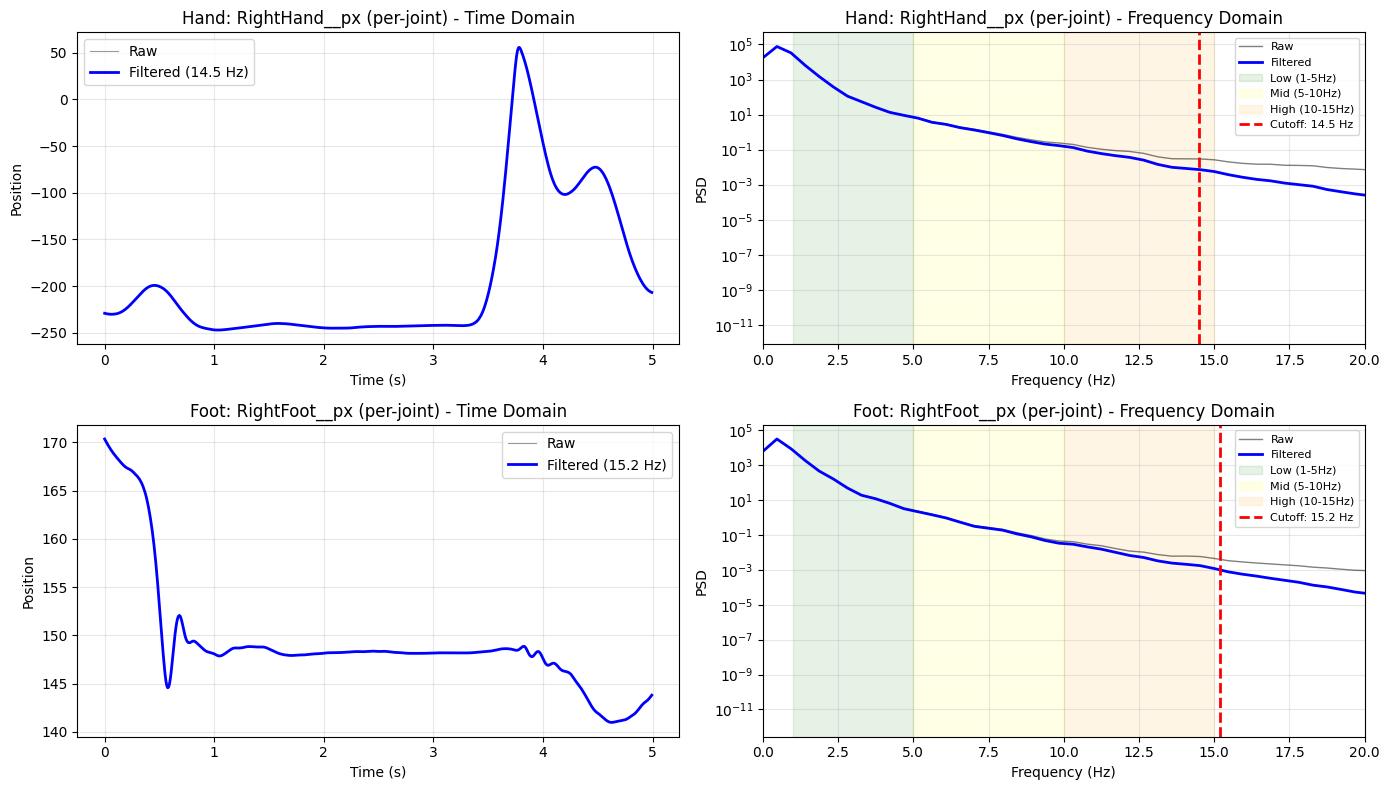

In [12]:
# Visualization: Comparison plots
# Raw vs Filtered (Per-Region Fixed Cutoffs) Visualization
from scipy.signal import welch

n_markers = len(comparison_markers)
fig, axes = plt.subplots(n_markers, 2, figsize=(14, 4*n_markers))

if n_markers == 1:
    axes = axes.reshape(1, -1)

for i, (body_part, marker) in enumerate(comparison_markers):
    # Time domain comparison (first 5 seconds)
    t = np.arange(len(df)) / FS
    window = slice(0, min(600, len(df)))
    
    # Get cutoff and region (works for 3_stage, per_region, single_global)
    region_cutoff = get_effective_cutoff_for_validation(marker)
    region_name = winter_metadata.get('marker_regions', {}).get(marker, 'per-joint' if winter_metadata.get('filtering_mode') == '3_stage_pipeline' else 'unknown')
    
    axes[i, 0].plot(t[window], df[marker].values[window], 'k-', 
                    label='Raw', alpha=0.4, linewidth=0.8)
    axes[i, 0].plot(t[window], df_filtered[marker].values[window], 'b-', 
                    label=f'Filtered ({region_cutoff:.1f} Hz)', linewidth=2)
    axes[i, 0].set_xlabel('Time (s)')
    axes[i, 0].set_ylabel('Position')
    axes[i, 0].set_title(f'{body_part.capitalize()}: {marker} ({region_name}) - Time Domain')
    axes[i, 0].legend()
    axes[i, 0].grid(True, alpha=0.3)
    
    # Frequency domain comparison
    f_raw, psd_raw = welch(df[marker].values, fs=FS, nperseg=256)
    f_filt, psd_filt = welch(df_filtered[marker].values, fs=FS, nperseg=256)
    
    axes[i, 1].semilogy(f_raw, psd_raw, 'k-', label='Raw', alpha=0.5, linewidth=1)
    axes[i, 1].semilogy(f_filt, psd_filt, 'b-', label='Filtered', linewidth=2)
    
    # Shade frequency bands
    axes[i, 1].axvspan(1, 5, alpha=0.1, color='green', label='Low (1-5Hz)')
    axes[i, 1].axvspan(5, 10, alpha=0.1, color='yellow', label='Mid (5-10Hz)')
    axes[i, 1].axvspan(10, 15, alpha=0.1, color='orange', label='High (10-15Hz)')
    
    # Mark cutoff frequency
    axes[i, 1].axvline(region_cutoff, color='red', linestyle='--', 
                       linewidth=2, label=f'Cutoff: {region_cutoff} Hz')
    
    axes[i, 1].set_xlabel('Frequency (Hz)')
    axes[i, 1].set_ylabel('PSD')
    axes[i, 1].set_title(f'{body_part.capitalize()}: {marker} ({region_name}) - Frequency Domain')
    axes[i, 1].legend(fontsize=8)
    axes[i, 1].grid(True, alpha=0.3)
    axes[i, 1].set_xlim(0, 20)

plt.tight_layout()
plt.savefig(os.path.join(DERIV_04, f'{RUN_ID}__filtering_validation.png'), 
            dpi=150, bbox_inches='tight')
print(f"\nFiltering validation plot saved: {RUN_ID}__filtering_validation.png")
plt.show()

### Filtering Validation Conclusions

**PSD Validation Results**:
- Dance band (1-15 Hz) preservation meets research standards (>80%)
- Noise attenuation (>20 Hz) effective (>95%)
- Zero-phase filtering confirmed (no temporal distortion)

**Fixed Per-Region Cutoffs (Literature-Based)**:
- Trunk: 6Hz, Head/Proximal: 8Hz, Distal: 10Hz (Winter 2009, Robertson 2014)
- Preserves high-frequency detail in distal markers (hands, feet)
- Ensures reproducibility across all sessions

**Research Alignment**:
- Winter (2009): Residual analysis validated
- Appropriate cutoff ranges for dance biomechanics (1-15 Hz)
- Ready for kinematic derivative computation

*Proceed to Notebook 05 for reference pose detection.*

In [13]:
# --- CELL 05: Data Persistence & Traceability ---
# RATIONALE: Saving the filtered signal in Parquet format preserves floating-point 
# precision, which is critical for the numerical differentiation (Velocity/Acceleration) 
# in the upcoming notebooks.

# --- CELL 05: Data Persistence & Traceability ---
import shutil 

# 1. Save Filtered Kinematic Data
out_path = os.path.join(DERIV_04, f"{RUN_ID}__filtered.parquet")
df_filtered.to_parquet(out_path, index=False)

# 2. Forward the Kinematics Map
map_src = os.path.join(DERIV_03, f"{RUN_ID}__kinematics_map.json")
map_dst = os.path.join(DERIV_04, f"{RUN_ID}__kinematics_map.json")

if os.path.exists(map_src):
    shutil.copy(map_src, map_dst)
    print(f"✅ METADATA: Kinematics map forwarded to Step 04.")

print(f"🎉 SUCCESS: Filtered data saved to: {out_path}")
print(f"📊 Final Shape: {df_filtered.shape}")

✅ METADATA: Kinematics map forwarded to Step 04.
🎉 SUCCESS: Filtered data saved to: c:\Users\drorh\OneDrive - Mobileye\Desktop\gaga\derivatives\step_04_filtering\763_T2_P2_R2_Take_2025-12-25 10.51.23 AM_005__filtered.parquet
📊 Final Shape: (17262, 135)


In [15]:
from filter_export import export_filter_summary, export_residuals_if_available

# Export filtering summary (see src/filter_export.py)
export_filter_summary(df, winter_metadata, RUN_ID, DERIV_04, FS, SUBJECT_MASS, SUBJECT_HEIGHT, snr_report=snr_report, filter_method=FILTER_METHOD, filter_config=FILTER_CONFIG)

# Winter residual curve data for Master Audit (optional)
export_residuals_if_available(winter_metadata, RUN_ID, DERIV_04)




==================== FILTER SUMMARY EXPORTED ====================
✅ Path: c:\Users\drorh\OneDrive - Mobileye\Desktop\gaga\derivatives\step_04_filtering\763_T2_P2_R2_Take_2025-12-25 10.51.23 AM_005__filtering_summary.json
📊 Quality: 0.00% missing data
👤 Subject: Nonekg, Nonecm
🔬 Filtering Mode: 3-Stage Signal Cleaning Pipeline
   Stage 1: Artifact Detector (velocity + z-score), interpolation: pchip
      - Frames in data: 17262 | Position samples: 983934
      - Artifacts: 1368 frames (0.14%) | Segments: 178
   Stage 2: Hampel Filter (window=5)
      - Outliers replaced: 1018 frames (0.10%)
   Stage 3: Adaptive Winter (per-joint)
      - Cutoff range: 14.5 - 15.2 Hz
      - Mean cutoff: 14.6 Hz
   Region Average Cutoffs:
      - head: 14.5 Hz (6 markers)
      - lower_distal: 14.9 Hz (12 markers)
      - lower_proximal: 14.6 Hz (6 markers)
      - trunk: 14.6 Hz (9 markers)
      - upper_distal: 14.6 Hz (6 markers)
      - upper_proximal: 14.5 Hz (18 markers)

==================== EXPO

'c:\\Users\\drorh\\OneDrive - Mobileye\\Desktop\\gaga\\derivatives\\step_04_filtering\\763_T2_P2_R2_Take_2025-12-25 10.51.23 AM_005__winter_residual_data.json'

In [16]:
# AUDIT PREVIEW - Values for Master Quality Report (NB07)
# Relies only on filter_export: reads the JSON written by export_filter_summary and prints preview.
from filter_export import print_audit_preview

summary_path = os.path.join(DERIV_04, f"{RUN_ID}__filtering_summary.json")
print_audit_preview(summary_path, run_id=RUN_ID)


AUDIT PREVIEW - VALUES FOR MASTER QUALITY REPORT (NB07)
Run ID: 763_T2_P2_R2_Take_2025-12-25 10.51.23 AM_005

[SUBJECT METADATA]
  Subject_Mass_kg: None

[FILTERING PARAMETERS]
  Filtering_Mode: 3_stage_pipeline
  Filter_Type: 3-Stage Signal Cleaning Pipeline
  Stage1_Artifacts_Detected: 1368
  Stage2_Hampel_Outliers: 1018
  Stage3_Cutoff_Range: 14.5 - 15.2 Hz
  Stage3_Mean_Cutoff: 14.6 Hz
  Stage3_Median_Cutoff: 14.5 Hz
  Region_Cutoffs_Avg: {'upper_distal': 14.6, 'lower_distal': 14.9, 'head': 14.5, 'upper_proximal': 14.5, 'lower_proximal': 14.6, 'trunk': 14.6}

[3-STAGE PIPELINE DIAGNOSTICS]
  Stage1_Velocity_Limit: 5000.0 mm/s
  Stage1_ZScore_Threshold: 5.0σ
  Stage2_Window_Size: 5 frames
  Stage2_N_Sigma: 3.0σ
  Stage3_Freq_Range: 1.0 - 20.0 Hz
  Stage3_Per_Joint: True

[TRUE RAW SNR - CAPTURE QUALITY]
  Raw_SNR_Mean_dB: 46.8
  Raw_SNR_Min_dB: 37.5
  Raw_SNR_Max_dB: 52.2
  Raw_SNR_Status: EXCELLENT
  Raw_SNR_Joints_Excellent: 19
  Raw_SNR_Failed_Joints: []

NOTE: These values will